In [ ]:
# you will be prompted with a window asking to grant permissions
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
datadir = "./"
if not os.path.exists(datadir):
  !ln -s "/content/drive/My Drive/Your/Assignment3/path/" $datadir # TODO: Fill your Assignment 3 path
os.chdir(datadir)
!pwd

In [ ]:
# In a terminal, Run the `download_data.sh` script in the data folder of assignment 3 part 2

In [1]:
import os
import random

import cv2
import numpy as np

import torch
from torch.utils.data import DataLoader
from torchvision import models

from src.resnet_yolo import resnet50
from yolo_loss import YoloLoss
from src.dataset import VocDetectorDataset
from src.eval_voc import evaluate
from src.predict import predict_image
from src.config import VOC_CLASSES, COLORS
from kaggle_submission import output_submission_csv

import matplotlib.pyplot as plt
import collections

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Initialization

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# YOLO network hyperparameters
B = 2  # number of bounding box predictions per cell
S = 14  # width/height of network output grid (larger than 7x7 from paper since we use a different network)

To implement Yolo we will rely on a pretrained classifier as the backbone for our detection network. PyTorch offers a variety of models which are pretrained on ImageNet in the [`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html) package. In particular, we will use the ResNet50 architecture as a base for our detector. This is different from the base architecture in the Yolo paper and also results in a different output grid size (14x14 instead of 7x7).

Models are typically pretrained on ImageNet since the dataset is very large (> 1 million images) and widely used. The pretrained model provides a very useful weight initialization for our detector, so that the network is able to learn quickly and effectively.

In [4]:
load_network_path = 'checkpoints/best_detector.pth' 
pretrained = True

# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    net = resnet50().to(device)
    net.load_state_dict(torch.load(load_network_path))
else:
    print('Load pre-trained model')
    net = resnet50(pretrained=pretrained).to(device)

Loading saved network from checkpoints/best_detector.pth


In [6]:
learning_rate = 0.001
num_epochs = 50
batch_size = 48

# Yolo loss component coefficients (as given in Yolo v1 paper)
lambda_coord = 5
lambda_noobj = 0.5

## Reading Pascal Data

Since Pascal is a small dataset (5000 in train+val) we have combined the train and val splits to train our detector. This is not typically a good practice, but we will make an exception in this case to be able to get reasonable detection results with a comparatively small object detection dataset.

The train dataset loader also using a variety of data augmentation techniques including random shift, scaling, crop, and flips. Data augmentation is slightly more complicated for detection datasets since the bounding box annotations must be kept consistent throughout the transformations.

Since the output of the detector network we train is an SxSx(B*5+C), we use an encoder to convert the original bounding box coordinates into relative grid bounding box coordinates corresponding to the expected output. We also use a decoder which allows us to convert the opposite direction into image coordinate bounding boxes.

In [7]:
file_root_train = r"data/VOCdevkit_2007/VOC2007/JPEGImages/"
annotation_file_train = "data/voc2007.txt"

train_dataset = VocDetectorDataset(root_img_dir=file_root_train,dataset_file=annotation_file_train,train=True, S=S)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=2)
print('Loaded %d train images' % len(train_dataset))

Initializing dataset
Loaded 5011 train images


In [8]:
file_root_test = "data/VOCdevkit_2007/VOC2007test/JPEGImages/"
annotation_file_test = "data/voc2007test.txt"

test_dataset = VocDetectorDataset(root_img_dir=file_root_test,dataset_file=annotation_file_test,train=False, S=S)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=2)
print('Loaded %d test images' % len(test_dataset))

Initializing dataset
Loaded 4950 test images


In [9]:
data = train_dataset[0]
print(data)

(tensor([[[-116., -106., -100.,  ..., -108., -107., -110.],
         [-115., -103.,  -94.,  ..., -104., -105., -109.],
         [-111., -112.,  -93.,  ..., -104., -106., -110.],
         ...,
         [ -85.,  -95.,  -93.,  ..., -102., -100.,  -97.],
         [ -78.,  -88.,  -87.,  ..., -103., -103.,  -99.],
         [ -74.,  -84.,  -83.,  ..., -102., -100.,  -97.]],

        [[-102.,  -96.,  -98.,  ...,  -97.,  -95.,  -98.],
         [-104.,  -93.,  -90.,  ...,  -93.,  -93.,  -96.],
         [-103., -104.,  -83.,  ...,  -92.,  -94.,  -97.],
         ...,
         [ -74.,  -80.,  -74.,  ...,  -80.,  -77.,  -74.],
         [ -69.,  -77.,  -70.,  ...,  -81.,  -79.,  -75.],
         [ -65.,  -73.,  -66.,  ...,  -80.,  -76.,  -73.]],

        [[ -86.,  -78.,  -75.,  ...,  -85.,  -84.,  -87.],
         [ -88.,  -76.,  -70.,  ...,  -82.,  -82.,  -87.],
         [ -91.,  -90.,  -71.,  ...,  -84.,  -84.,  -90.],
         ...,
         [ -67.,  -75.,  -69.,  ...,  -77.,  -75.,  -72.],
         

## Set up training tools

In [10]:
criterion = YoloLoss(S, B, lambda_coord, lambda_noobj)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

## Train detector

In [11]:
best_test_loss = np.inf
learning_rate = 1e-3
for epoch in range(num_epochs):
    net.train()
    
    # Update learning rate late in training
    if epoch == 30 or epoch == 40:
        learning_rate /= 10.0

    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate
    
    print('\n\nStarting epoch %d / %d' % (epoch + 1, num_epochs))
    print('Learning Rate for this epoch: {}'.format(learning_rate))
    
    total_loss = collections.defaultdict(int)
    
    for i, data in enumerate(train_loader):
        data = (item.to(device) for item in data)
        images, target_boxes, target_cls, has_object_map = data
        pred = net(images)
        loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
        for key in loss_dict:
            total_loss[key] += loss_dict[key].item()
        
        optimizer.zero_grad()
        loss_dict['total_loss'].backward()
        optimizer.step()
        
        if (i+1) % 50 == 0:
            outstring = 'Epoch [%d/%d], Iter [%d/%d], Loss: ' % ((epoch+1, num_epochs, i+1, len(train_loader)))
            outstring += ', '.join( "%s=%.3f" % (key[:-5], val / (i+1)) for key, val in total_loss.items() )
            print(outstring)
    
    # evaluate the network on the test data
    if (epoch + 1) % 5 == 0:
        test_aps = evaluate(net, test_dataset_file=annotation_file_test, img_root=file_root_test)
        print(epoch, test_aps)
    with torch.no_grad():
        test_loss = 0.0
        net.eval()
        for i, data in enumerate(test_loader):
            data = (item.to(device) for item in data)
            images, target_boxes, target_cls, has_object_map = data
            
            pred = net(images)
            loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
            test_loss += loss_dict['total_loss'].item()
        test_loss /= len(test_loader)
    
    if best_test_loss > test_loss:
        best_test_loss = test_loss
        print('Updating best test loss: %.5f' % best_test_loss)
        torch.save(net.state_dict(),'checkpoints/best_detector.pth')
    
    if (epoch+1) in [5, 10, 20, 30, 40]:
        torch.save(net.state_dict(),'checkpoints/detector_epoch_%d.pth' % (epoch+1))

    torch.save(net.state_dict(),'checkpoints/detector.pth')
    




Starting epoch 1 / 50
Learning Rate for this epoch: 0.001
Epoch [1/50], Iter [50/209], Loss: total=23.023, reg=3.690, containing_obj=0.332, no_obj=12.304, cls=6.696
Epoch [1/50], Iter [100/209], Loss: total=14.953, reg=3.090, containing_obj=0.452, no_obj=6.371, cls=5.040
Epoch [1/50], Iter [150/209], Loss: total=12.040, reg=2.833, containing_obj=0.525, no_obj=4.349, cls=4.334
Epoch [1/50], Iter [200/209], Loss: total=10.444, reg=2.674, containing_obj=0.570, no_obj=3.322, cls=3.877
Updating best test loss: 5.28874


Starting epoch 2 / 50
Learning Rate for this epoch: 0.001
Epoch [2/50], Iter [50/209], Loss: total=5.168, reg=2.059, containing_obj=0.762, no_obj=0.197, cls=2.150
Epoch [2/50], Iter [100/209], Loss: total=5.136, reg=2.074, containing_obj=0.779, no_obj=0.184, cls=2.099
Epoch [2/50], Iter [150/209], Loss: total=5.020, reg=2.037, containing_obj=0.778, no_obj=0.174, cls=2.031
Epoch [2/50], Iter [200/209], Loss: total=4.918, reg=2.004, containing_obj=0.783, no_obj=0.165, cls=1.

100%|██████████| 4950/4950 [01:59<00:00, 41.33it/s]


---class aeroplane ap 0.07658872725054766---
---class bicycle ap 0.05062845689428884---
---class bird ap 0.06031496703720878---
---class boat ap 0.015634869227697974---
---class bottle ap 0.0161706925891787---
---class bus ap 0.0--- (no predictions for this class)
---class car ap 0.12292450106729097---
---class cat ap 0.0111731843575419---
---class chair ap 0.03533659231025792---
---class cow ap 0.0---
---class diningtable ap 0.0--- (no predictions for this class)
---class dog ap 0.004703476482617587---
---class horse ap 0.05198014629049112---
---class motorbike ap 0.0--- (no predictions for this class)
---class person ap 0.04971351804509193---
---class pottedplant ap 0.009684292097146533---
---class sheep ap 0.019559228650137744---
---class sofa ap 0.0--- (no predictions for this class)
---class train ap 0.0--- (no predictions for this class)
---class tvmonitor ap 0.16219807005625944---
---map 0.03433053611778785---
4 [0.07658872725054766, 0.05062845689428884, 0.06031496703720878, 0.0

100%|██████████| 4950/4950 [01:55<00:00, 42.94it/s]


---class aeroplane ap 0.29672594414934905---
---class bicycle ap 0.3422849102545965---
---class bird ap 0.26962383409735075---
---class boat ap 0.11380292495688714---
---class bottle ap 0.0465665892740073---
---class bus ap 0.25234830916967904---
---class car ap 0.4968924330943932---
---class cat ap 0.5211356780331985---
---class chair ap 0.16107418955618402---
---class cow ap 0.14420768319136462---
---class diningtable ap 0.0048543689320388345---
---class dog ap 0.44054838096319154---
---class horse ap 0.44923080267119464---
---class motorbike ap 0.3760258183215436---
---class person ap 0.2922193643238318---
---class pottedplant ap 0.06539052004378372---
---class sheep ap 0.18705394618455345---
---class sofa ap 0.16438100439114636---
---class train ap 0.45297452404630134---
---class tvmonitor ap 0.3515317055710824---
---map 0.2714436465612839---
9 [0.29672594414934905, 0.3422849102545965, 0.26962383409735075, 0.11380292495688714, 0.0465665892740073, 0.25234830916967904, 0.496892433094

100%|██████████| 4950/4950 [01:49<00:00, 45.00it/s]


---class aeroplane ap 0.353683881278508---
---class bicycle ap 0.5256176577417708---
---class bird ap 0.3356674510308097---
---class boat ap 0.16124285849869038---
---class bottle ap 0.08810782975750252---
---class bus ap 0.4250292824366394---
---class car ap 0.5366674313982549---
---class cat ap 0.598304841212767---
---class chair ap 0.2232592629911557---
---class cow ap 0.2789533399214591---
---class diningtable ap 0.05270457697642164---
---class dog ap 0.5249338844330504---
---class horse ap 0.5374441023029601---
---class motorbike ap 0.42264480520659303---
---class person ap 0.40555980096429206---
---class pottedplant ap 0.11200195599409636---
---class sheep ap 0.29994128351451826---
---class sofa ap 0.31837120455312473---
---class train ap 0.60919846631995---
---class tvmonitor ap 0.35808844254523087---
---map 0.3583711179538897---
14 [0.353683881278508, 0.5256176577417708, 0.3356674510308097, 0.16124285849869038, 0.08810782975750252, 0.4250292824366394, 0.5366674313982549, 0.5983

100%|██████████| 4950/4950 [01:50<00:00, 44.98it/s]


---class aeroplane ap 0.44728433469512224---
---class bicycle ap 0.5209844377553562---
---class bird ap 0.4001112153420066---
---class boat ap 0.1782360244094975---
---class bottle ap 0.12431433578342119---
---class bus ap 0.49089998788611183---
---class car ap 0.5543484487470753---
---class cat ap 0.5593981607331366---
---class chair ap 0.22098080775915271---
---class cow ap 0.42783670584498845---
---class diningtable ap 0.17728054829978707---
---class dog ap 0.5597769708665804---
---class horse ap 0.6254283583663549---
---class motorbike ap 0.5664770219279924---
---class person ap 0.4564772852679984---
---class pottedplant ap 0.1360019135184708---
---class sheep ap 0.3841037883120979---
---class sofa ap 0.4167732522132447---
---class train ap 0.5855054093211073---
---class tvmonitor ap 0.3582455920919174---
---map 0.40952322995707097---
19 [0.44728433469512224, 0.5209844377553562, 0.4001112153420066, 0.1782360244094975, 0.12431433578342119, 0.49089998788611183, 0.5543484487470753, 0.

100%|██████████| 4950/4950 [02:02<00:00, 40.43it/s]


---class aeroplane ap 0.5149458020731885---
---class bicycle ap 0.5106475588148521---
---class bird ap 0.46117354577234015---
---class boat ap 0.219702083376801---
---class bottle ap 0.15645203304209096---
---class bus ap 0.5717432535826358---
---class car ap 0.6270526877149574---
---class cat ap 0.6405853965777057---
---class chair ap 0.2519842755268026---
---class cow ap 0.35256324374888814---
---class diningtable ap 0.21343934006471996---
---class dog ap 0.5578261301333471---
---class horse ap 0.6606943988185616---
---class motorbike ap 0.5226537682252406---
---class person ap 0.48934373545790183---
---class pottedplant ap 0.15633199963217598---
---class sheep ap 0.4387286403033152---
---class sofa ap 0.45115321023353133---
---class train ap 0.6454942618790018---
---class tvmonitor ap 0.43682795137218233---
---map 0.44396716581751205---
24 [0.5149458020731885, 0.5106475588148521, 0.46117354577234015, 0.219702083376801, 0.15645203304209096, 0.5717432535826358, 0.6270526877149574, 0.6

100%|██████████| 4950/4950 [02:16<00:00, 36.25it/s]


---class aeroplane ap 0.4719819809800481---
---class bicycle ap 0.5780565318334638---
---class bird ap 0.4494709722559183---
---class boat ap 0.2924411458666887---
---class bottle ap 0.17512803769885577---
---class bus ap 0.562238838562554---
---class car ap 0.6349132255562765---
---class cat ap 0.6546596536208156---
---class chair ap 0.2358103752066274---
---class cow ap 0.34905603398848234---
---class diningtable ap 0.2802260169057064---
---class dog ap 0.5733626063495525---
---class horse ap 0.6389986491725825---
---class motorbike ap 0.5315041878862564---
---class person ap 0.49390194785564623---
---class pottedplant ap 0.15866587891490264---
---class sheep ap 0.4187775294345249---
---class sofa ap 0.42169926734926033---
---class train ap 0.63268485842851---
---class tvmonitor ap 0.47652801270692446---
---map 0.45150528752867986---
29 [0.4719819809800481, 0.5780565318334638, 0.4494709722559183, 0.2924411458666887, 0.17512803769885577, 0.562238838562554, 0.6349132255562765, 0.654659

100%|██████████| 4950/4950 [01:49<00:00, 45.06it/s]


---class aeroplane ap 0.5182232060568526---
---class bicycle ap 0.5928895331166626---
---class bird ap 0.457731500298588---
---class boat ap 0.303100847827348---
---class bottle ap 0.20191777763229413---
---class bus ap 0.61536422439128---
---class car ap 0.6348491083974395---
---class cat ap 0.6722168600532524---
---class chair ap 0.278135548608228---
---class cow ap 0.4256744403555651---
---class diningtable ap 0.3268612595417006---
---class dog ap 0.6281144088561152---
---class horse ap 0.6612629844143209---
---class motorbike ap 0.5394669509337908---
---class person ap 0.5128583117137296---
---class pottedplant ap 0.17264680245592376---
---class sheep ap 0.4384131127375066---
---class sofa ap 0.5061388734972234---
---class train ap 0.6908505299321648---
---class tvmonitor ap 0.4982419733310435---
---map 0.48374791270755146---
34 [0.5182232060568526, 0.5928895331166626, 0.457731500298588, 0.303100847827348, 0.20191777763229413, 0.61536422439128, 0.6348491083974395, 0.672216860053252

100%|██████████| 4950/4950 [01:48<00:00, 45.50it/s]


---class aeroplane ap 0.4963578587792927---
---class bicycle ap 0.5756793539323094---
---class bird ap 0.4759911861761871---
---class boat ap 0.34074504406841394---
---class bottle ap 0.2197668206159354---
---class bus ap 0.6013150829459295---
---class car ap 0.6693489716075912---
---class cat ap 0.6831885360371106---
---class chair ap 0.2823448817599529---
---class cow ap 0.477146367867021---
---class diningtable ap 0.34567166923093595---
---class dog ap 0.6629475806430277---
---class horse ap 0.6844687741865834---
---class motorbike ap 0.5525202917014421---
---class person ap 0.521253363990281---
---class pottedplant ap 0.18267193056813083---
---class sheep ap 0.4471823407575993---
---class sofa ap 0.5170200961599739---
---class train ap 0.705163039335304---
---class tvmonitor ap 0.489696876633244---
---map 0.4965240033498134---
39 [0.4963578587792927, 0.5756793539323094, 0.4759911861761871, 0.34074504406841394, 0.2197668206159354, 0.6013150829459295, 0.6693489716075912, 0.6831885360

100%|██████████| 4950/4950 [02:05<00:00, 39.43it/s]


---class aeroplane ap 0.512483127477515---
---class bicycle ap 0.5852869781267083---
---class bird ap 0.4803436960479395---
---class boat ap 0.32965797702728616---
---class bottle ap 0.230540525666382---
---class bus ap 0.6147311786261999---
---class car ap 0.6599836053944655---
---class cat ap 0.6758410380008759---
---class chair ap 0.2861696088756105---
---class cow ap 0.48210031349501703---
---class diningtable ap 0.352889673707156---
---class dog ap 0.6459057021764523---
---class horse ap 0.6800722319896104---
---class motorbike ap 0.5555304880513685---
---class person ap 0.5207299831311535---
---class pottedplant ap 0.1750900289035132---
---class sheep ap 0.45206182152757535---
---class sofa ap 0.505239520641471---
---class train ap 0.7003660216670626---
---class tvmonitor ap 0.5124488150235984---
---map 0.49787361677784797---
44 [0.512483127477515, 0.5852869781267083, 0.4803436960479395, 0.32965797702728616, 0.230540525666382, 0.6147311786261999, 0.6599836053944655, 0.67584103800

100%|██████████| 4950/4950 [01:49<00:00, 45.04it/s]


---class aeroplane ap 0.5173585424561593---
---class bicycle ap 0.583714545511857---
---class bird ap 0.470908732081237---
---class boat ap 0.3220532102661491---
---class bottle ap 0.22284560678560017---
---class bus ap 0.6070306394455354---
---class car ap 0.6581933465351568---
---class cat ap 0.6884812056830767---
---class chair ap 0.2801820451820764---
---class cow ap 0.4824978902261956---
---class diningtable ap 0.33360376561974125---
---class dog ap 0.659913921396504---
---class horse ap 0.693596605213306---
---class motorbike ap 0.5690485472680742---
---class person ap 0.5323960906993205---
---class pottedplant ap 0.18505575579428019---
---class sheep ap 0.44878501670270876---
---class sofa ap 0.5058467567143687---
---class train ap 0.6846409861475697---
---class tvmonitor ap 0.520872493525345---
---map 0.49835128516271326---
49 [0.5173585424561593, 0.583714545511857, 0.470908732081237, 0.3220532102661491, 0.22284560678560017, 0.6070306394455354, 0.6581933465351568, 0.68848120568

In [11]:
load_network_path = 'checkpoints/best_detector.pth' 
pretrained = True

# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    net = resnet50().to(device)
    net.load_state_dict(torch.load(load_network_path))
else:
    print('Load pre-trained model')
    net = resnet50(pretrained=pretrained).to(device)

Loading saved network from checkpoints/best_detector.pth


In [16]:
# train for another 20 epochs
best_test_loss = np.inf
learning_rate = 1e-7
num_epochs = 20
for epoch in range(num_epochs):
    net.train()
    
    # Update learning rate late in training
    # if epoch == 10:
    #     learning_rate /= 10.0

    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate
    
    print('\n\nStarting epoch %d / %d' % (epoch + 1, num_epochs))
    print('Learning Rate for this epoch: {}'.format(learning_rate))
    
    total_loss = collections.defaultdict(int)
    
    for i, data in enumerate(train_loader):
        data = (item.to(device) for item in data)
        images, target_boxes, target_cls, has_object_map = data
        pred = net(images)
        loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
        for key in loss_dict:
            total_loss[key] += loss_dict[key].item()
        
        optimizer.zero_grad()
        loss_dict['total_loss'].backward()
        optimizer.step()
        
        if (i+1) % 50 == 0:
            outstring = 'Epoch [%d/%d], Iter [%d/%d], Loss: ' % ((epoch+1, num_epochs, i+1, len(train_loader)))
            outstring += ', '.join( "%s=%.3f" % (key[:-5], val / (i+1)) for key, val in total_loss.items() )
            print(outstring)
    
    # evaluate the network on the test data
    if (epoch + 1) % 5 == 0:
        test_aps = evaluate(net, test_dataset_file=annotation_file_test, img_root=file_root_test)
        print(epoch, test_aps)
    with torch.no_grad():
        test_loss = 0.0
        net.eval()
        for i, data in enumerate(test_loader):
            data = (item.to(device) for item in data)
            images, target_boxes, target_cls, has_object_map = data
            
            pred = net(images)
            loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
            test_loss += loss_dict['total_loss'].item()
        test_loss /= len(test_loader)
    
    if best_test_loss > test_loss:
        best_test_loss = test_loss
        print('Updating best test loss: %.5f' % best_test_loss)
        # torch.save(net.state_dict(),'checkpoints/best_detector.pth')
    
    if (epoch+1) in [5, 10]:
        torch.save(net.state_dict(),'checkpoints/detector_epoch_%d.pth' % (epoch+1))

    torch.save(net.state_dict(),'checkpoints/detector.pth')



Starting epoch 1 / 20
Learning Rate for this epoch: 1e-07
Epoch [1/20], Iter [50/105], Loss: total=1.752, reg=0.847, containing_obj=0.559, no_obj=0.202, cls=0.144
Epoch [1/20], Iter [100/105], Loss: total=1.760, reg=0.856, containing_obj=0.555, no_obj=0.201, cls=0.148
Updating best test loss: 2.67042


Starting epoch 2 / 20
Learning Rate for this epoch: 1e-07
Epoch [2/20], Iter [50/105], Loss: total=1.727, reg=0.813, containing_obj=0.552, no_obj=0.205, cls=0.157
Epoch [2/20], Iter [100/105], Loss: total=1.738, reg=0.829, containing_obj=0.554, no_obj=0.205, cls=0.150
Updating best test loss: 2.66498


Starting epoch 3 / 20
Learning Rate for this epoch: 1e-07
Epoch [3/20], Iter [50/105], Loss: total=1.729, reg=0.835, containing_obj=0.545, no_obj=0.202, cls=0.148
Epoch [3/20], Iter [100/105], Loss: total=1.777, reg=0.857, containing_obj=0.559, no_obj=0.202, cls=0.159


Starting epoch 4 / 20
Learning Rate for this epoch: 1e-07
Epoch [4/20], Iter [50/105], Loss: total=1.817, reg=0.869, co

100%|██████████| 4950/4950 [01:45<00:00, 46.90it/s]


---class aeroplane ap 0.5156360272465859---
---class bicycle ap 0.5821791933248942---
---class bird ap 0.4754608255767426---
---class boat ap 0.32956161643160997---
---class bottle ap 0.23962633438956316---
---class bus ap 0.6098380274170774---
---class car ap 0.6648527938897819---
---class cat ap 0.6839515576802225---
---class chair ap 0.2838002041505672---
---class cow ap 0.47104410313192613---
---class diningtable ap 0.3477910782984703---
---class dog ap 0.6620648664117479---
---class horse ap 0.6918500943034918---
---class motorbike ap 0.5617132807435516---
---class person ap 0.5268194852696351---
---class pottedplant ap 0.17710022135345396---
---class sheep ap 0.46297048589591366---
---class sofa ap 0.5044173320168852---
---class train ap 0.7046449198400089---
---class tvmonitor ap 0.507086273890087---
---map 0.5001204360631107---
4 [0.5156360272465859, 0.5821791933248942, 0.4754608255767426, 0.32956161643160997, 0.23962633438956316, 0.6098380274170774, 0.6648527938897819, 0.68395

KeyboardInterrupt: 

# View example predictions

predicting...


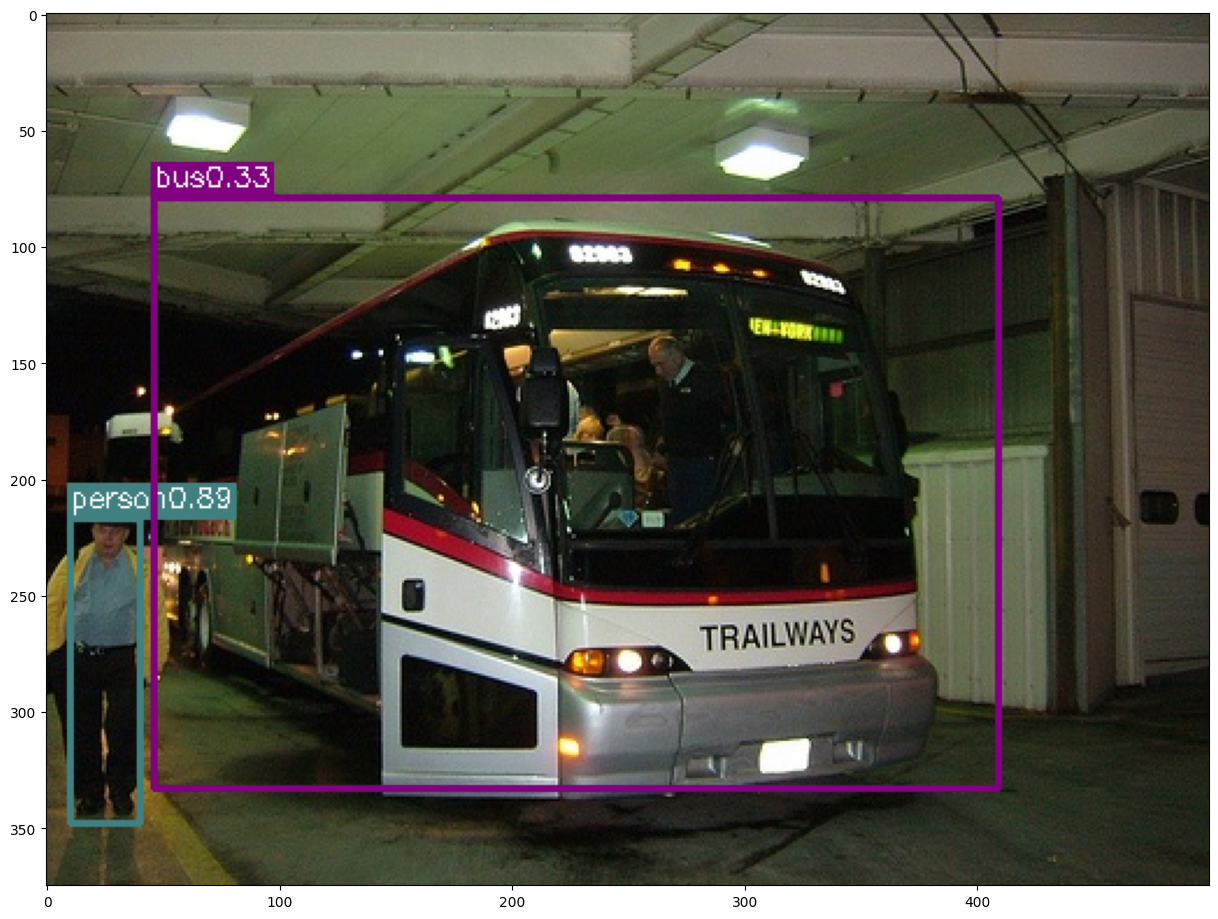

In [16]:
net.eval()

# select random image from test set
image_name = random.choice(test_dataset.fnames)
image = cv2.imread(os.path.join(file_root_test, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print('predicting...')
result = predict_image(net, image_name, root_img_directory=file_root_test)
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)


## Evaluate on Test

To evaluate detection results we use mAP (mean of average precision over each class)

In [17]:
test_aps = evaluate(net, test_dataset_file=annotation_file_test, img_root=file_root_test)

---Evaluate model on test samples---


100%|██████████| 4950/4950 [01:44<00:00, 47.40it/s]


---class aeroplane ap 0.5156360272465859---
---class bicycle ap 0.5821791933248942---
---class bird ap 0.4754608255767426---
---class boat ap 0.32956161643160997---
---class bottle ap 0.23962633438956316---
---class bus ap 0.6098380274170774---
---class car ap 0.6648527938897819---
---class cat ap 0.6839515576802225---
---class chair ap 0.2838002041505672---
---class cow ap 0.47104410313192613---
---class diningtable ap 0.3477910782984703---
---class dog ap 0.6620648664117479---
---class horse ap 0.6918500943034918---
---class motorbike ap 0.5617132807435516---
---class person ap 0.5268194852696351---
---class pottedplant ap 0.17710022135345396---
---class sheep ap 0.46297048589591366---
---class sofa ap 0.5044173320168852---
---class train ap 0.7046449198400089---
---class tvmonitor ap 0.507086273890087---
---map 0.5001204360631107---


### Cell added to get intermediate mAP values for students

In [18]:
network_paths = ['./checkpoints/detector_epoch_%d.pth' % epoch for epoch in [5, 10, 20, 30, 40]]+['./checkpoints/detector.pth']
for load_network_path in network_paths:
    print('Loading saved network from {}'.format(load_network_path))
    net_loaded =  resnet50().to(device)
    net_loaded.load_state_dict(torch.load(load_network_path))
    evaluate(net_loaded, test_dataset_file=annotation_file_test, img_root=file_root_test)


Loading saved network from ./checkpoints/detector_epoch_5.pth
---Evaluate model on test samples---


100%|██████████| 4950/4950 [01:33<00:00, 53.02it/s]


---class aeroplane ap 0.07658872725054766---
---class bicycle ap 0.05062845689428884---
---class bird ap 0.06031496703720878---
---class boat ap 0.015634869227697974---
---class bottle ap 0.0161706925891787---
---class bus ap 0.0--- (no predictions for this class)
---class car ap 0.12292450106729097---
---class cat ap 0.0111731843575419---
---class chair ap 0.03533659231025792---
---class cow ap 0.0---
---class diningtable ap 0.0--- (no predictions for this class)
---class dog ap 0.004703476482617587---
---class horse ap 0.05198014629049112---
---class motorbike ap 0.0--- (no predictions for this class)
---class person ap 0.04971351804509193---
---class pottedplant ap 0.009684292097146533---
---class sheep ap 0.019559228650137744---
---class sofa ap 0.0--- (no predictions for this class)
---class train ap 0.0--- (no predictions for this class)
---class tvmonitor ap 0.16219807005625944---
---map 0.03433053611778785---
Loading saved network from ./checkpoints/detector_epoch_10.pth
---Eva

100%|██████████| 4950/4950 [01:41<00:00, 48.83it/s]


---class aeroplane ap 0.29672594414934905---
---class bicycle ap 0.3422849102545965---
---class bird ap 0.26962383409735075---
---class boat ap 0.11380292495688714---
---class bottle ap 0.0465665892740073---
---class bus ap 0.25234830916967904---
---class car ap 0.4968924330943932---
---class cat ap 0.5211356780331985---
---class chair ap 0.16107418955618402---
---class cow ap 0.14420768319136462---
---class diningtable ap 0.0048543689320388345---
---class dog ap 0.44054838096319154---
---class horse ap 0.44923080267119464---
---class motorbike ap 0.3760258183215436---
---class person ap 0.2922193643238318---
---class pottedplant ap 0.06539052004378372---
---class sheep ap 0.18705394618455345---
---class sofa ap 0.16438100439114636---
---class train ap 0.45297452404630134---
---class tvmonitor ap 0.3515317055710824---
---map 0.2714436465612839---
Loading saved network from ./checkpoints/detector_epoch_20.pth
---Evaluate model on test samples---


100%|██████████| 4950/4950 [01:51<00:00, 44.27it/s]


---class aeroplane ap 0.44728433469512224---
---class bicycle ap 0.5209844377553562---
---class bird ap 0.4001112153420066---
---class boat ap 0.1782360244094975---
---class bottle ap 0.12431433578342119---
---class bus ap 0.49089998788611183---
---class car ap 0.5543484487470753---
---class cat ap 0.5593981607331366---
---class chair ap 0.22098080775915271---
---class cow ap 0.42783670584498845---
---class diningtable ap 0.17728054829978707---
---class dog ap 0.5597769708665804---
---class horse ap 0.6254283583663549---
---class motorbike ap 0.5664770219279924---
---class person ap 0.4564772852679984---
---class pottedplant ap 0.1360019135184708---
---class sheep ap 0.3841037883120979---
---class sofa ap 0.4167732522132447---
---class train ap 0.5855054093211073---
---class tvmonitor ap 0.3582455920919174---
---map 0.40952322995707097---
Loading saved network from ./checkpoints/detector_epoch_30.pth
---Evaluate model on test samples---


100%|██████████| 4950/4950 [01:51<00:00, 44.30it/s]


---class aeroplane ap 0.4719819809800481---
---class bicycle ap 0.5780565318334638---
---class bird ap 0.4494709722559183---
---class boat ap 0.2924411458666887---
---class bottle ap 0.17512803769885577---
---class bus ap 0.562238838562554---
---class car ap 0.6349132255562765---
---class cat ap 0.6546596536208156---
---class chair ap 0.2358103752066274---
---class cow ap 0.34905603398848234---
---class diningtable ap 0.2802260169057064---
---class dog ap 0.5733626063495525---
---class horse ap 0.6389986491725825---
---class motorbike ap 0.5315041878862564---
---class person ap 0.49390194785564623---
---class pottedplant ap 0.15866587891490264---
---class sheep ap 0.4187775294345249---
---class sofa ap 0.42169926734926033---
---class train ap 0.63268485842851---
---class tvmonitor ap 0.47652801270692446---
---map 0.45150528752867986---
Loading saved network from ./checkpoints/detector_epoch_40.pth
---Evaluate model on test samples---


100%|██████████| 4950/4950 [01:48<00:00, 45.72it/s]


---class aeroplane ap 0.4963578587792927---
---class bicycle ap 0.5756793539323094---
---class bird ap 0.4759911861761871---
---class boat ap 0.34074504406841394---
---class bottle ap 0.2197668206159354---
---class bus ap 0.6013150829459295---
---class car ap 0.6693489716075912---
---class cat ap 0.6831885360371106---
---class chair ap 0.2823448817599529---
---class cow ap 0.477146367867021---
---class diningtable ap 0.34567166923093595---
---class dog ap 0.6629475806430277---
---class horse ap 0.6844687741865834---
---class motorbike ap 0.5525202917014421---
---class person ap 0.521253363990281---
---class pottedplant ap 0.18267193056813083---
---class sheep ap 0.4471823407575993---
---class sofa ap 0.5170200961599739---
---class train ap 0.705163039335304---
---class tvmonitor ap 0.489696876633244---
---map 0.4965240033498134---
Loading saved network from ./checkpoints/detector.pth
---Evaluate model on test samples---


100%|██████████| 4950/4950 [02:00<00:00, 40.91it/s]


---class aeroplane ap 0.5173585424561593---
---class bicycle ap 0.583714545511857---
---class bird ap 0.470908732081237---
---class boat ap 0.3220532102661491---
---class bottle ap 0.22284560678560017---
---class bus ap 0.6070306394455354---
---class car ap 0.6581933465351568---
---class cat ap 0.6884812056830767---
---class chair ap 0.2801820451820764---
---class cow ap 0.4824978902261956---
---class diningtable ap 0.33360376561974125---
---class dog ap 0.659913921396504---
---class horse ap 0.693596605213306---
---class motorbike ap 0.5690485472680742---
---class person ap 0.5323960906993205---
---class pottedplant ap 0.18505575579428019---
---class sheep ap 0.44878501670270876---
---class sofa ap 0.5058467567143687---
---class train ap 0.6846409861475697---
---class tvmonitor ap 0.520872493525345---
---map 0.49835128516271326---


In [18]:
output_submission_csv('my_new_solution.csv', test_aps)

# Extra Credit 1: Video Object Detection

In [45]:
import numpy as np
import cv2
import pafy
import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image
from tqdm import trange

import torch
from torch import nn
from torchvision import transforms

url = "https://www.youtube.com/watch?v=xZGahvrep3o"

In [9]:
!pip install pytube

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 297.8 kB/s eta 0:00:000:00:01


In [72]:
### Download YouTube Video ###
from pytube import YouTube
url = "https://www.youtube.com/watch?v=xZGahvrep3o"
path = "./video"
video = YouTube(url)
video.streams.filter(progressive=True)
stream = video.streams.get_by_itag(22)
stream.download(path)

'/u/qilong/mistral/mistral2/./video/SNL Digital Short YOLO - SNL.mp4'

In [20]:
### Video to Frame ###
 
def video2frame(videos_path,frames_save_path,time_interval):
 
    '''
    :param videos_path: path to video
    :param frames_save_path: path to frames
    :param time_interval: time interval
    :return:
    '''
    vidcap = cv2.VideoCapture(videos_path)
    success, image = vidcap.read()
    count = 0
    while success:
        success, image = vidcap.read()
        count += 1
        if count % time_interval == 0:
            try:
                cv2.imencode('.jpg', image)[1].tofile(frames_save_path + "/%d.jpg" % count)
            except:
                break
    print(count)

    return count

In [73]:
videos_path = r'./video/SNL_Digital_Short_YOLO_SNL.mp4'
frames_save_path = r'./video/frame2'
time_interval = 2
count = video2frame(videos_path, frames_save_path, time_interval)

5265


In [74]:
### Load Detector ###
load_network_path = "checkpoints/best_detector.pth"
pretrained = True

# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    net = resnet50().to(device)
    net.load_state_dict(torch.load(load_network_path))
else:
    print('Load pre-trained model')
    net = resnet50(pretrained=pretrained).to(device)

Loading saved network from checkpoints/best_detector.pth


True

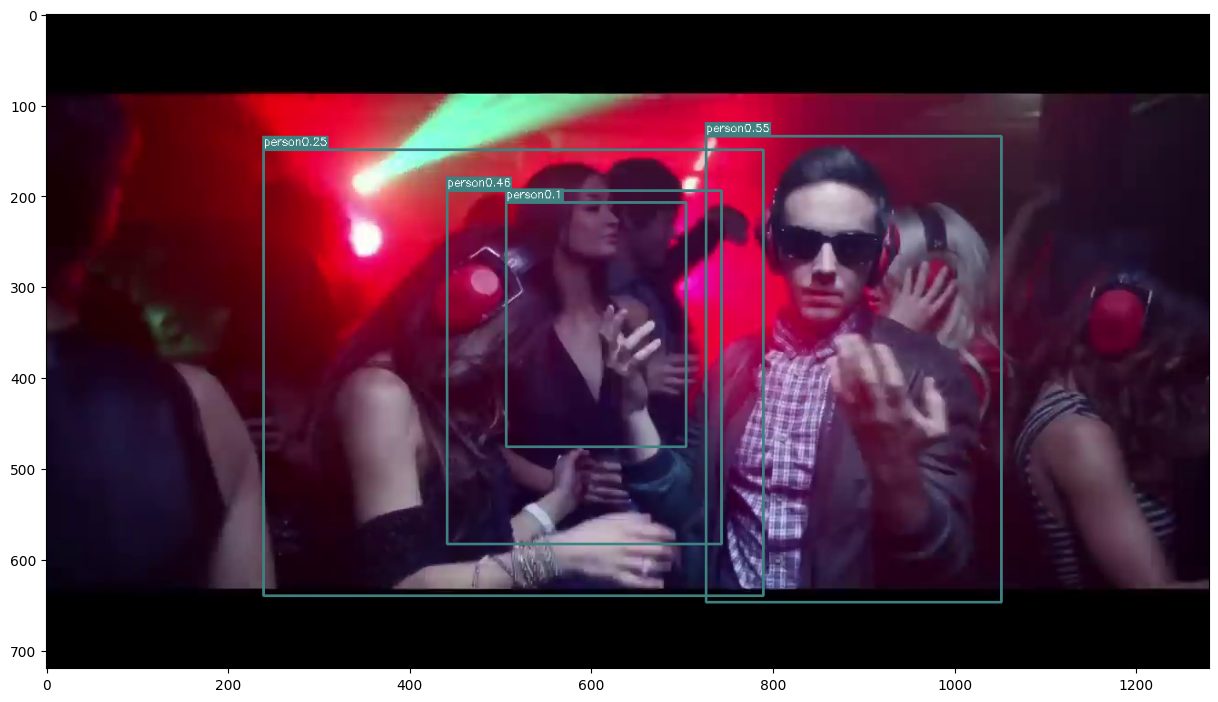

In [76]:
### Test on one frame ###
net.eval()
detected_save_path = "./video/detected2"

# load image from frame
idx = 100
image = cv2.imread(frames_save_path + "/{}.jpg".format(idx * 10))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

result = predict_image(net, "{}.jpg".format(idx * 10), root_img_directory=frames_save_path + "/")
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

# show image
plt.figure(figsize = (15,15))
plt.imshow(image)

# save image
cv2.imwrite(detected_save_path + "/{}.jpg".format(idx * 10), image)

In [79]:
### Detection ###
net.eval()
detected_save_path = "./video/detected2"
if count is None:
    count = 5265

# load image from frame
for i in trange(count // time_interval):
    idx = i + 1
    try:
        image = cv2.imread("./video/frame2/{}.jpg".format(idx * time_interval))
    except:
        print("Can not load frame {}".format(idx * time_interval))
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    result = predict_image(net, "{}.jpg".format(idx * time_interval), root_img_directory="./video/frame2/")
    for left_up, right_bottom, class_name, _, prob in result:
        color = COLORS[VOC_CLASSES.index(class_name)]
        cv2.rectangle(image, left_up, right_bottom, color, 2)
        label = class_name + str(round(prob, 2))
        text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
        p1 = (left_up[0], left_up[1] - text_size[1])
        cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]), color, -1)
        cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

    # save image
    cv2.imwrite(detected_save_path + "/{}.jpg".format(idx * time_interval), image)

100%|██████████| 2632/2632 [02:17<00:00, 19.16it/s]


In [80]:
### Frame to Video ###
 
def frame2video(im_dir,video_dir,fps):
 
    im_list = []
    for idx in range(1, count // time_interval + 1):
        im_list.append("{}.jpg".format(idx * time_interval))
    img = Image.open(im_dir + im_list[100])
    img_size = img.size
    print(img_size)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    videoWriter = cv2.VideoWriter(video_dir, fourcc, fps, img_size)

    print("Start producing video...")
    for i in trange(len(im_list)):
        im_name = im_dir + im_list[i]
        frame = cv2.imread(im_name)
        videoWriter.write(frame)
    videoWriter.release()
    print('finish')

In [81]:
im_dir =  detected_save_path + "/"
video_dir = r'./video/detected2_video.mp4'
fps = 24
frame2video(im_dir, video_dir, fps)

(1280, 720)
Start producing video...


100%|██████████| 2632/2632 [00:32<00:00, 81.15it/s]

finish


# Extra Credit 2: Better Pretrained Model

In [87]:
from src.resnet_yolo import resnet101

load_network_path = None #'checkpoints/best_detector.pth' 
pretrained = True

# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    net = resnet101().to(device)
    net.load_state_dict(torch.load(load_network_path))
else:
    print('Load pre-trained model')
    net = resnet101(pretrained=pretrained).to(device)

Load pre-trained model


In [88]:
learning_rate = 0.001
num_epochs = 50
batch_size = 24

# Yolo loss component coefficients (as given in Yolo v1 paper)
lambda_coord = 5
lambda_noobj = 0.5

criterion = YoloLoss(S, B, lambda_coord, lambda_noobj)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

In [89]:
best_test_loss = np.inf
for epoch in range(num_epochs):
    net.train()
    
    # Update learning rate late in training
    if epoch == 30 or epoch == 40:
        learning_rate /= 10.0

    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate
    
    print('\n\nStarting epoch %d / %d' % (epoch + 1, num_epochs))
    print('Learning Rate for this epoch: {}'.format(learning_rate))
    
    total_loss = collections.defaultdict(int)
    
    for i, data in enumerate(train_loader):
        data = (item.to(device) for item in data)
        images, target_boxes, target_cls, has_object_map = data
        pred = net(images)
        loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
        for key in loss_dict:
            total_loss[key] += loss_dict[key].item()
        
        optimizer.zero_grad()
        loss_dict['total_loss'].backward()
        optimizer.step()
        
        if (i+1) % 50 == 0:
            outstring = 'Epoch [%d/%d], Iter [%d/%d], Loss: ' % ((epoch+1, num_epochs, i+1, len(train_loader)))
            outstring += ', '.join( "%s=%.3f" % (key[:-5], val / (i+1)) for key, val in total_loss.items() )
            print(outstring)
    
    # evaluate the network on the test data
    if (epoch + 1) % 5 == 0:
        test_aps = evaluate(net, test_dataset_file=annotation_file_test, img_root=file_root_test)
        print(epoch, test_aps)
    with torch.no_grad():
        test_loss = 0.0
        net.eval()
        for i, data in enumerate(test_loader):
            data = (item.to(device) for item in data)
            images, target_boxes, target_cls, has_object_map = data
            
            pred = net(images)
            loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
            test_loss += loss_dict['total_loss'].item()
        test_loss /= len(test_loader)
    
    if best_test_loss > test_loss:
        best_test_loss = test_loss
        print('Updating best test loss: %.5f' % best_test_loss)
        torch.save(net.state_dict(),'checkpoints/res101_best_detector.pth')
    
    if (epoch+1) in [5, 10, 20, 30, 40]:
        torch.save(net.state_dict(),'checkpoints/res101_detector_epoch_%d.pth' % (epoch+1))

    torch.save(net.state_dict(),'checkpoints/res101_detector.pth')



Starting epoch 1 / 50
Learning Rate for this epoch: 0.001
Epoch [1/50], Iter [50/209], Loss: total=23.906, reg=3.820, containing_obj=0.347, no_obj=12.476, cls=7.263
Epoch [1/50], Iter [100/209], Loss: total=15.517, reg=3.252, containing_obj=0.453, no_obj=6.467, cls=5.345
Epoch [1/50], Iter [150/209], Loss: total=12.311, reg=2.919, containing_obj=0.516, no_obj=4.418, cls=4.458
Epoch [1/50], Iter [200/209], Loss: total=10.481, reg=2.697, containing_obj=0.555, no_obj=3.377, cls=3.852
Updating best test loss: 5.02656


Starting epoch 2 / 50
Learning Rate for this epoch: 0.001
Epoch [2/50], Iter [50/209], Loss: total=4.768, reg=1.978, containing_obj=0.740, no_obj=0.204, cls=1.846
Epoch [2/50], Iter [100/209], Loss: total=4.751, reg=1.962, containing_obj=0.764, no_obj=0.190, cls=1.835
Epoch [2/50], Iter [150/209], Loss: total=4.743, reg=1.963, containing_obj=0.778, no_obj=0.179, cls=1.824
Epoch [2/50], Iter [200/209], Loss: total=4.652, reg=1.935, containing_obj=0.786, no_obj=0.169, cls=1.

100%|██████████| 4950/4950 [02:15<00:00, 36.62it/s]

---class aeroplane ap 0.0---
---class bicycle ap 0.0--- (no predictions for this class)
---class bird ap 0.0--- (no predictions for this class)
---class boat ap 0.0--- (no predictions for this class)
---class bottle ap 0.0--- (no predictions for this class)
---class bus ap 0.0--- (no predictions for this class)
---class car ap 0.0--- (no predictions for this class)
---class cat ap 0.0--- (no predictions for this class)
---class chair ap 0.0--- (no predictions for this class)
---class cow ap 0.0--- (no predictions for this class)
---class diningtable ap 0.0--- (no predictions for this class)
---class dog ap 0.0--- (no predictions for this class)
---class horse ap 0.0--- (no predictions for this class)
---class motorbike ap 0.0--- (no predictions for this class)
---class person ap 0.0--- (no predictions for this class)
---class pottedplant ap 0.0--- (no predictions for this class)
---class sheep ap 0.0--- (no predictions for this class)
---class sofa ap 0.0--- (no predictions for this cl

Updating best test loss: 3.66728


Starting epoch 6 / 50
Learning Rate for this epoch: 0.001
Epoch [6/50], Iter [50/209], Loss: total=3.335, reg=1.534, containing_obj=0.952, no_obj=0.066, cls=0.784
Epoch [6/50], Iter [100/209], Loss: total=3.348, reg=1.557, containing_obj=0.945, no_obj=0.065, cls=0.780
Epoch [6/50], Iter [150/209], Loss: total=3.405, reg=1.583, containing_obj=0.971, no_obj=0.064, cls=0.787
Epoch [6/50], Iter [200/209], Loss: total=3.371, reg=1.571, containing_obj=0.966, no_obj=0.063, cls=0.771
Updating best test loss: 3.58269


Starting epoch 7 / 50
Learning Rate for this epoch: 0.001
Epoch [7/50], Iter [50/209], Loss: total=3.310, reg=1.555, containing_obj=0.997, no_obj=0.059, cls=0.699
Epoch [7/50], Iter [100/209], Loss: total=3.281, reg=1.546, containing_obj=0.994, no_obj=0.059, cls=0.682
Epoch [7/50], Iter [150/209], Loss: total=3.210, reg=1.513, containing_obj=0.979, no_obj=0.058, cls=0.660
Epoch [7/50], Iter [200/209], Loss: total=3.220, reg=1.514, containing_obj

100%|██████████| 4950/4950 [02:16<00:00, 36.20it/s]


---class aeroplane ap 0.37014882268865834---
---class bicycle ap 0.33202984858019907---
---class bird ap 0.32980370752002586---
---class boat ap 0.17872398942594217---
---class bottle ap 0.03817529058860585---
---class bus ap 0.39699784808851935---
---class car ap 0.5011312021898204---
---class cat ap 0.48249772972528926---
---class chair ap 0.166253515159359---
---class cow ap 0.3905101878308053---
---class diningtable ap 0.0048543689320388345---
---class dog ap 0.5036399047043938---
---class horse ap 0.5081073248781507---
---class motorbike ap 0.20567201037109883---
---class person ap 0.37773878026190766---
---class pottedplant ap 0.0719055271847999---
---class sheep ap 0.21640730222603838---
---class sofa ap 0.14106169740623525---
---class train ap 0.49811441302951087---
---class tvmonitor ap 0.40449863737274727---
---map 0.3059136054082073---
9 [0.37014882268865834, 0.33202984858019907, 0.32980370752002586, 0.17872398942594217, 0.03817529058860585, 0.39699784808851935, 0.5011312021

100%|██████████| 4950/4950 [02:24<00:00, 34.36it/s]


---class aeroplane ap 0.4356732454051556---
---class bicycle ap 0.44810200781632786---
---class bird ap 0.3801434682582944---
---class boat ap 0.29092424903022696---
---class bottle ap 0.12055072478432052---
---class bus ap 0.5441086483550813---
---class car ap 0.5993128759021323---
---class cat ap 0.5496272609274507---
---class chair ap 0.20023555237683116---
---class cow ap 0.49366906046884235---
---class diningtable ap 0.14186838954549316---
---class dog ap 0.5555851985361089---
---class horse ap 0.5968196230312743---
---class motorbike ap 0.4222586849264899---
---class person ap 0.37512585571712664---
---class pottedplant ap 0.1738742044375341---
---class sheep ap 0.416266436233785---
---class sofa ap 0.30789329560014533---
---class train ap 0.5761414438038914---
---class tvmonitor ap 0.36003730538745715---
---map 0.3994108765271985---
14 [0.4356732454051556, 0.44810200781632786, 0.3801434682582944, 0.29092424903022696, 0.12055072478432052, 0.5441086483550813, 0.5993128759021323, 0

100%|██████████| 4950/4950 [02:23<00:00, 34.58it/s]


---class aeroplane ap 0.4500290385934387---
---class bicycle ap 0.6119677548336837---
---class bird ap 0.47045234354917054---
---class boat ap 0.33807746224643087---
---class bottle ap 0.17938049648987325---
---class bus ap 0.5857919548744188---
---class car ap 0.6546783146730449---
---class cat ap 0.6193989618047662---
---class chair ap 0.2984238286421016---
---class cow ap 0.5704814432674307---
---class diningtable ap 0.1726416483340955---
---class dog ap 0.6256145581359478---
---class horse ap 0.6486127212155299---
---class motorbike ap 0.4805464038752212---
---class person ap 0.49900208745793134---
---class pottedplant ap 0.2053964101368331---
---class sheep ap 0.4259484914784117---
---class sofa ap 0.4440582509298917---
---class train ap 0.6016929814373102---
---class tvmonitor ap 0.4807186224829285---
---map 0.46814568872292306---
19 [0.4500290385934387, 0.6119677548336837, 0.47045234354917054, 0.33807746224643087, 0.17938049648987325, 0.5857919548744188, 0.6546783146730449, 0.61

100%|██████████| 4950/4950 [02:09<00:00, 38.27it/s]


---class aeroplane ap 0.4493943018533752---
---class bicycle ap 0.5815049295793329---
---class bird ap 0.40438008537311365---
---class boat ap 0.3059144934344722---
---class bottle ap 0.1880503664061213---
---class bus ap 0.5294113446256266---
---class car ap 0.6277563886035822---
---class cat ap 0.6563460194727262---
---class chair ap 0.2818475300113292---
---class cow ap 0.46979663971899654---
---class diningtable ap 0.2724369353427165---
---class dog ap 0.6138955865319873---
---class horse ap 0.6640598729179764---
---class motorbike ap 0.48992167955986476---
---class person ap 0.5380842520165102---
---class pottedplant ap 0.15371697792721345---
---class sheep ap 0.4520906661645119---
---class sofa ap 0.4427459560395489---
---class train ap 0.5235328183834421---
---class tvmonitor ap 0.46897552682954124---
---map 0.45569311853959943---
24 [0.4493943018533752, 0.5815049295793329, 0.40438008537311365, 0.3059144934344722, 0.1880503664061213, 0.5294113446256266, 0.6277563886035822, 0.656

100%|██████████| 4950/4950 [02:11<00:00, 37.68it/s]


---class aeroplane ap 0.4370347377431284---
---class bicycle ap 0.6063564896750449---
---class bird ap 0.4513877136383035---
---class boat ap 0.3177819913946993---
---class bottle ap 0.22718827519784496---
---class bus ap 0.6232368912901032---
---class car ap 0.6722871253118491---
---class cat ap 0.5940839534050067---
---class chair ap 0.32175522703517934---
---class cow ap 0.5520750850568417---
---class diningtable ap 0.2596434021904313---
---class dog ap 0.5652328641056429---
---class horse ap 0.6683811709784176---
---class motorbike ap 0.5780252501379156---
---class person ap 0.5511284046251623---
---class pottedplant ap 0.20948417858732127---
---class sheep ap 0.44027965034567046---
---class sofa ap 0.4079782852830158---
---class train ap 0.5780049653813829---
---class tvmonitor ap 0.5218785526769412---
---map 0.47916121070299517---
29 [0.4370347377431284, 0.6063564896750449, 0.4513877136383035, 0.3177819913946993, 0.22718827519784496, 0.6232368912901032, 0.6722871253118491, 0.5940

100%|██████████| 4950/4950 [02:26<00:00, 33.73it/s]


---class aeroplane ap 0.5124813531391292---
---class bicycle ap 0.6406666728820745---
---class bird ap 0.5267294913528213---
---class boat ap 0.3520827537300927---
---class bottle ap 0.23707125023635497---
---class bus ap 0.6381050036675867---
---class car ap 0.6898492314049264---
---class cat ap 0.6869430381256758---
---class chair ap 0.32649655488905494---
---class cow ap 0.5229444279305109---
---class diningtable ap 0.32013941508431654---
---class dog ap 0.6362180706662386---
---class horse ap 0.6834630980947245---
---class motorbike ap 0.6141312524877574---
---class person ap 0.5667527822081906---
---class pottedplant ap 0.22793007147545105---
---class sheep ap 0.46117512972559727---
---class sofa ap 0.4738739595996908---
---class train ap 0.6174561207624698---
---class tvmonitor ap 0.5261043183866694---
---map 0.5130306997924666---
34 [0.5124813531391292, 0.6406666728820745, 0.5267294913528213, 0.3520827537300927, 0.23707125023635497, 0.6381050036675867, 0.6898492314049264, 0.6869

100%|██████████| 4950/4950 [02:19<00:00, 35.40it/s]


---class aeroplane ap 0.5041299236726144---
---class bicycle ap 0.6702644041146242---
---class bird ap 0.5443064755457228---
---class boat ap 0.34595750439014633---
---class bottle ap 0.24733893947292582---
---class bus ap 0.6477820421617064---
---class car ap 0.6934408739149409---
---class cat ap 0.6793073088527579---
---class chair ap 0.3329980944348795---
---class cow ap 0.5591092977325537---
---class diningtable ap 0.3303599087870781---
---class dog ap 0.6339171482342213---
---class horse ap 0.7086375921419621---
---class motorbike ap 0.6158403105188133---
---class person ap 0.565730483438492---
---class pottedplant ap 0.22363083087776076---
---class sheep ap 0.5013237735445348---
---class sofa ap 0.4762274064285803---
---class train ap 0.6200301629226648---
---class tvmonitor ap 0.5077442503051058---
---map 0.5204038365746043---
39 [0.5041299236726144, 0.6702644041146242, 0.5443064755457228, 0.34595750439014633, 0.24733893947292582, 0.6477820421617064, 0.6934408739149409, 0.679307

100%|██████████| 4950/4950 [02:18<00:00, 35.72it/s]


---class aeroplane ap 0.5281957531118149---
---class bicycle ap 0.6787577370933039---
---class bird ap 0.5471821781273337---
---class boat ap 0.371997979324474---
---class bottle ap 0.24145822286658025---
---class bus ap 0.6387569872644105---
---class car ap 0.6910533909333798---
---class cat ap 0.6815432789489099---
---class chair ap 0.3370886467266352---
---class cow ap 0.556894605082036---
---class diningtable ap 0.336280279594243---
---class dog ap 0.6324824447097587---
---class horse ap 0.691316028434873---
---class motorbike ap 0.6006904397326223---
---class person ap 0.57728022472045---
---class pottedplant ap 0.22064712850499352---
---class sheep ap 0.49075543672158295---
---class sofa ap 0.4660795964177883---
---class train ap 0.6189256732133483---
---class tvmonitor ap 0.5111932286065323---
---map 0.5209289630067535---
44 [0.5281957531118149, 0.6787577370933039, 0.5471821781273337, 0.371997979324474, 0.24145822286658025, 0.6387569872644105, 0.6910533909333798, 0.6815432789489

100%|██████████| 4950/4950 [02:19<00:00, 35.59it/s]


---class aeroplane ap 0.5313191239370854---
---class bicycle ap 0.6576073499532791---
---class bird ap 0.5366736391270497---
---class boat ap 0.37716124846787535---
---class bottle ap 0.24085737575341248---
---class bus ap 0.6485617792947089---
---class car ap 0.687869477840831---
---class cat ap 0.6731492633349193---
---class chair ap 0.3445235890792374---
---class cow ap 0.5548337618464732---
---class diningtable ap 0.350204457200313---
---class dog ap 0.6516651484153018---
---class horse ap 0.6954082953991244---
---class motorbike ap 0.6141076107499881---
---class person ap 0.5783747980777809---
---class pottedplant ap 0.22892791858007538---
---class sheep ap 0.4697638239596463---
---class sofa ap 0.4842278084485112---
---class train ap 0.6416915438594533---
---class tvmonitor ap 0.5286599705774611---
---map 0.5247793991951263---
49 [0.5313191239370854, 0.6576073499532791, 0.5366736391270497, 0.37716124846787535, 0.24085737575341248, 0.6485617792947089, 0.687869477840831, 0.67314926

predicting...


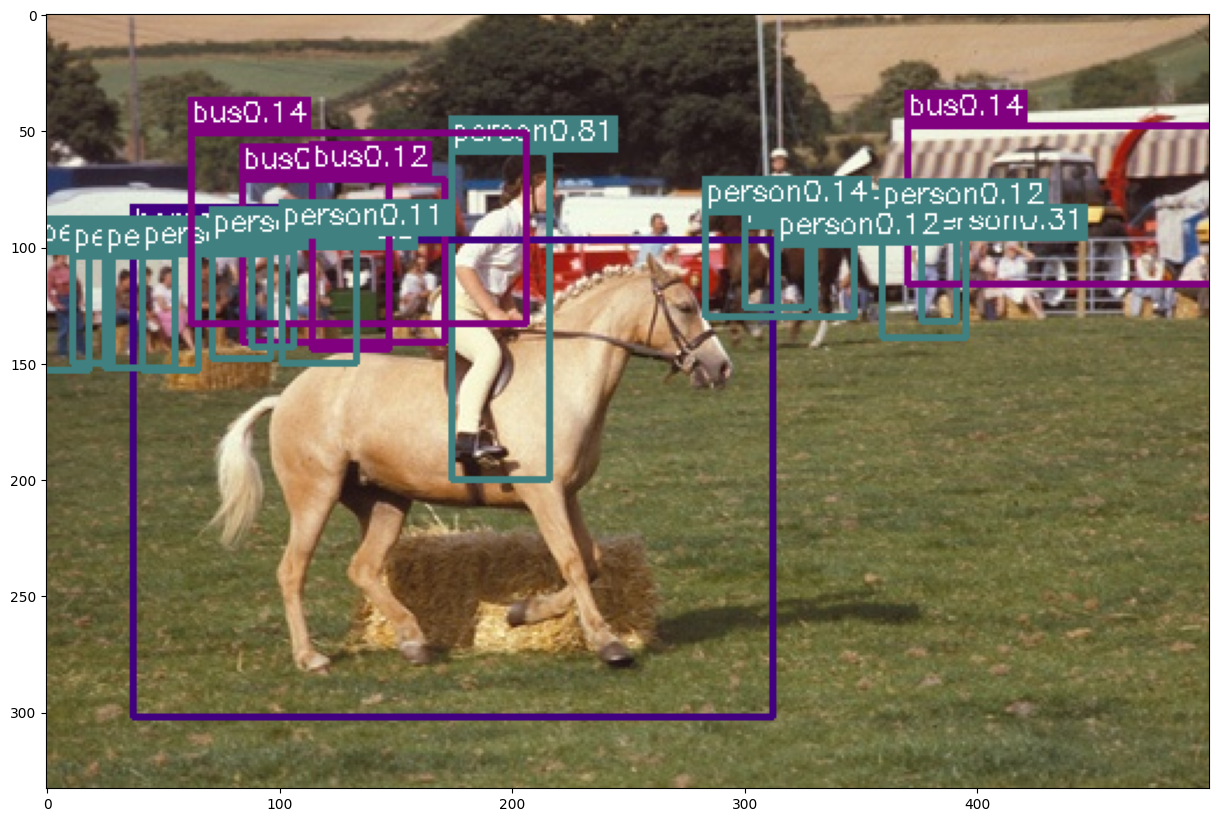

In [94]:
### Print Prediction ###
net.eval()

# select random image from test set
image_name = random.choice(test_dataset.fnames)
image = cv2.imread(os.path.join(file_root_test, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print('predicting...')
result = predict_image(net, image_name, root_img_directory=file_root_test)
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)

In [95]:
### Evaluate on Test ###
test_aps = evaluate(net, test_dataset_file=annotation_file_test, img_root=file_root_test)

---Evaluate model on test samples---


100%|██████████| 4950/4950 [02:24<00:00, 34.37it/s]


---class aeroplane ap 0.5313191239370854---
---class bicycle ap 0.6576073499532791---
---class bird ap 0.5366736391270497---
---class boat ap 0.37716124846787535---
---class bottle ap 0.24085737575341248---
---class bus ap 0.6485617792947089---
---class car ap 0.687869477840831---
---class cat ap 0.6731492633349193---
---class chair ap 0.3445235890792374---
---class cow ap 0.5548337618464732---
---class diningtable ap 0.350204457200313---
---class dog ap 0.6516651484153018---
---class horse ap 0.6954082953991244---
---class motorbike ap 0.6141076107499881---
---class person ap 0.5783747980777809---
---class pottedplant ap 0.22892791858007538---
---class sheep ap 0.4697638239596463---
---class sofa ap 0.4842278084485112---
---class train ap 0.6416915438594533---
---class tvmonitor ap 0.5286599705774611---
---map 0.5247793991951263---
